In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#  Image Classification for Cattle CVD Detection via Retina Images

### Importing important libraries

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Data Preprocessing

In [13]:
#Loading images
base_dir = '/kaggle/input/cvd-vs-noncvd-retinal-images-of-cattle/retina_healthy_unhealthy'
IMAGE_SIZE = (224, 224)      #resizing image
BATCH_SIZE = 32              # Batch size for training and validation
EPOCHS = 15
DATA_PATH = base_dir

# Enhanced Data Augmentation
datagen = ImageDataGenerator(
    #Rescaling pixel values to the range [0, 1]
    rescale=1.0/255.0,
     # 20% of data will be used as validation set
    validation_split=0.2,
    
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)



Found 895 images belonging to 2 classes.
Found 223 images belonging to 2 classes.


## Defining Model Architecture

In [14]:
# Importing necessary modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l2  # Importing L2 regularization

# Defining Model Architecture
model = Sequential([
    # Convolutional layer with L2 regularization
    Conv2D(16, (3, 3), activation='relu', input_shape=(*IMAGE_SIZE, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),  # Batch normalization to stabilize training
    MaxPooling2D((2, 2)),  # Max pooling layer to downsample the spatial dimensions
    
    # Additional convolutional layers
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Flatten the feature map before passing to fully connected layers
    Flatten(),
    
    # Dense layers for classification
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(2, activation='softmax')  # Output layer with softmax activation for multi-class classification
])


## Compiling Model

In [15]:
# Importing necessary modules
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Using Adam optimizer with a learning rate of 0.001
    loss='binary_crossentropy',            # Binary cross-entropy loss for binary classification
    metrics=['accuracy']                   # Track accuracy during training
)


In [16]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 222, 222, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 109, 109, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 93312)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       5,972,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,977,442 (22.80 MB)

 Trainable params: 5,977,346 (22.80 MB)

 Non-trainable params: 96 (384.00 B)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Callbacks for Early Stopping and Learning Rate Adjustment
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

## Training Model

In [18]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5705 - loss: 1.3767 - val_accuracy: 0.5112 - val_loss: 0.8490 - learning_rate: 1.0000e-04
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 33s 914ms/step - accuracy: 0.5788 - loss: 0.8518 - val_accuracy: 0.5112 - val_loss: 0.8515 - learning_rate: 1.0000e-04
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 33s 928ms/step - accuracy: 0.5996 - loss: 0.8052 - val_accuracy: 0.4753 - val_loss: 1.0236 - learning_rate: 1.0000e-04
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 33s 925ms/step - accuracy: 0.6179 - loss: 0.7900 - val_accuracy: 0.4619 - val_loss: 0.9493 - learning_rate: 1.0000e-04


## Training VGG16 Model

In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

base_dir = '/kaggle/input/cvd-vs-noncvd-retinal-images-of-cattle/retina_healthy_unhealthy'
IMAGE_SIZE = (224, 224)  # VGG16 requires 224x224 input size
BATCH_SIZE = 32
EPOCHS = 10
DATA_PATH = base_dir

# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Prepare Training and Validation Data
train_data = datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Load Pre-trained VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))

# Freeze Pre-trained Layers
for layer in base_model.layers:
    layer.trainable = False

# Add Custom Layers on Top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling reduces dimensionality
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)  # Fully connected layer
x = Dropout(0.3)(x)  # Dropout for regularization
predictions = Dense(train_data.num_classes, activation='softmax')(x)  # Output layer

# Define the Model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# Train the Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=callbacks
)


Found 895 images belonging to 2 classes.
Found 223 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 15,242,050 (58.14 MB)

 Trainable params: 527,362 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5326 - loss: 1.3736 - val_accuracy: 0.5830 - val_loss: 1.3078 - learning_rate: 1.0000e-04
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 966ms/step - accuracy: 0.5146 - loss: 1.3141 - val_accuracy: 0.5605 - val_loss: 1.2527 - learning_rate: 1.0000e-04
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 980ms/step - accuracy: 0.5025 - loss: 1.2612 - val_accuracy: 0.5919 - val_loss: 1.1952 - learning_rate: 1.0000e-04
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 994ms/step - accuracy: 0.5474 - loss: 1.1977 - val_accuracy: 0.5695 - val_loss: 1.1503 - learning_rate: 1.0000e-04
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 986ms/step - accuracy: 0.5392 - loss: 1.1664 - val_accuracy: 0.6457 - val_loss: 1.1027 - learning_rate: 1.0000e-04
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 985ms/step - accuracy: 0.5160 - loss: 1.1342 - val_accuracy: 0.5964 - val_loss: 1.0688 - learning_rate: 1.0000e-04
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 33s 947ms/step - accura

## Training Resnet18 Model using pytorch

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split


In [23]:
# Custom Dataset class for retinal images
class RetinalDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

## Data Preprocessing

In [24]:
# Data preprocessing
def prepare_data(data_dir):
    healthy_dir = os.path.join(data_dir, '0')
    unhealthy_dir = os.path.join(data_dir, '1')
    
    healthy_images = [os.path.join(healthy_dir, f) for f in os.listdir(healthy_dir) if f.endswith('.JPG')]
    unhealthy_images = [os.path.join(unhealthy_dir, f) for f in os.listdir(unhealthy_dir) if f.endswith('.JPG')]
    
    all_images = healthy_images + unhealthy_images
    labels = [0] * len(healthy_images) + [1] * len(unhealthy_images)
    
    return train_test_split(all_images, labels, test_size=0.2, random_state=42)


## Model Defination

In [25]:
# Model definition
class RetinalClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(RetinalClassifier, self).__init__()
        # Using ResNet18 as base model
        self.model = models.resnet18(pretrained=True)
        # Replace the final layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [26]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model = model.to(device)
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * correct / total
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * val_correct / val_total
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {running_loss/len(train_loader):.4f}')
        print(f'Training Accuracy: {train_acc:.2f}%')
        print(f'Validation Accuracy: {val_acc:.2f}%')
        print('--------------------')

In [27]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data augmentation and normalization
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
])
# Prepare data
data_dir = '/kaggle/input/cvd-vs-noncvd-retinal-images-of-cattle/retina_healthy_unhealthy/'
X_train, X_val, y_train, y_val = prepare_data(data_dir)

In [28]:
# Create datasets
train_dataset = RetinalDataset(X_train, y_train, transform=transform)
val_dataset = RetinalDataset(X_val, y_val, transform=transform)

In [29]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Model Training

In [30]:
model = RetinalClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s] 


Epoch [1/10]
Training Loss: 0.5894
Training Accuracy: 68.23%
Validation Accuracy: 78.12%
--------------------
Epoch [2/10]
Training Loss: 0.1576
Training Accuracy: 96.09%
Validation Accuracy: 85.27%
--------------------
Epoch [3/10]
Training Loss: 0.0462
Training Accuracy: 99.22%
Validation Accuracy: 87.95%
--------------------
Epoch [4/10]
Training Loss: 0.0288
Training Accuracy: 98.88%
Validation Accuracy: 86.61%
--------------------
Epoch [5/10]
Training Loss: 0.0197
Training Accuracy: 99.22%
Validation Accuracy: 89.29%
--------------------
Epoch [6/10]
Training Loss: 0.0174
Training Accuracy: 98.88%
Validation Accuracy: 88.39%
--------------------
Epoch [7/10]
Training Loss: 0.0191
Training Accuracy: 99.11%
Validation Accuracy: 87.05%
--------------------
Epoch [8/10]
Training Loss: 0.0148
Training Accuracy: 99.11%
Validation Accuracy: 85.71%
--------------------
Epoch [9/10]
Training Loss: 0.0134
Training Accuracy: 98.88%
Validation Accuracy: 88.84%
--------------------
Epoch [10/

## Evaluating the model using metrics like accuracy, precision, recall, f1 score and AUC-ROC

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.91      0.89      0.90       109
   Unhealthy       0.90      0.91      0.91       115

    accuracy                           0.90       224
   macro avg       0.90      0.90      0.90       224
weighted avg       0.90      0.90      0.90       224



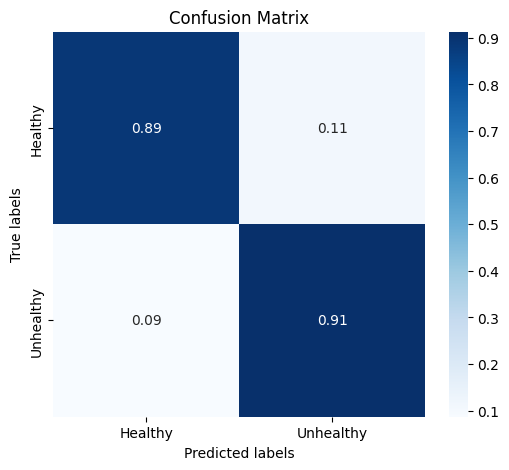

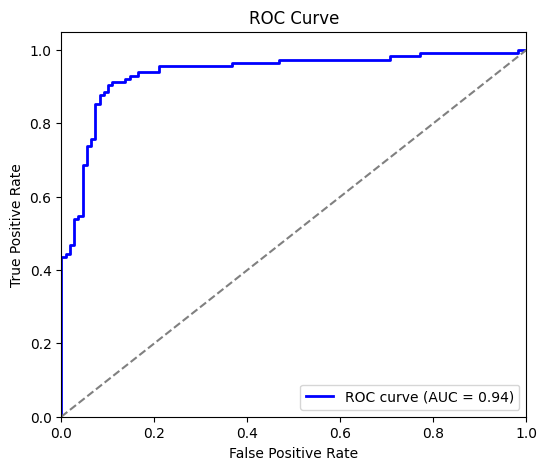

AUC-ROC: 0.94


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import torch

# Function to plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the matrix

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

# Function to plot ROC Curve and AUC-ROC score
def plot_roc_curve(y_true, y_probs, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random chance line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Function to evaluate and plot metrics
def evaluate_and_plot(model, val_loader, device='cuda'):
    model = model.to(device)
    model.eval()  # Set model to evaluation mode
    
    all_preds = []
    all_labels = []
    all_probs = []  # For ROC-AUC

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass to get predictions
            outputs = model(images)
            
            # Get the predicted labels
            _, predicted = outputs.max(1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            
            
            prob = torch.softmax(outputs, dim=1)[:, 1]  
            all_probs.append(prob.cpu().numpy())
    
    # Flatten the lists
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)
    
    # Print Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Healthy', 'Unhealthy']))
    
    # Plot Confusion Matrix
    plot_confusion_matrix(all_labels, all_preds, classes=['Healthy', 'Unhealthy'])

    # Plot ROC Curve and AUC-ROC
    plot_roc_curve(all_labels, all_probs)

    # Calculate and print AUC-ROC score
    auc_roc = auc(roc_curve(all_labels, all_probs)[0], roc_curve(all_labels, all_probs)[1])
    print(f"AUC-ROC: {auc_roc:.2f}")

# After training, evaluate and plot the metrics
evaluate_and_plot(model, val_loader, device=device)
